In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Optimizing trough GMRES

This example demostrates how it is possible to take advantage of the [`implicit function theorem`](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html#Implicit-function-differentiation-of-iterative-implementations) to differentiate trough a fixed point algorithm with $O(1)$ memory requirement, Here, the iterative solver is given by GMRES, which is used to solve the Helmholtz equation.

A great discussion about taking derivatives of a generic fixed-point algorithm is given in the [DEQ paper](https://arxiv.org/pdf/2006.08656.pdf)

### Helmholtz equation

The Helmholtz equation is given by Fourier transforming the wave equation in the temporal domain, which gives

$$
    \left(\nabla +\frac{\omega^2}{c^2}\right)\phi = \rho,
$$

with $\phi, \rho \in C^{\infty}(\mathbb{C})$. We'll assume to transmit waves from a set of $n$ transducers, which act as monopole sources: that means that we can define an apodization vector 

$$
\mathbf a = (a_0, \dots, a_n), \qquad a_i \in \mathbb{C}, \; \|a_i\| < 1
$$

such that $\rho(\mathbf a)$ is the transmit wavefield. The unit norm constraint is needed to enforce the fact that each transducer has an upper limit on the maximum power it can transmit.

We could use several methods to represent this vector and its constraint. Here, we use

$$
a_j(\rho_j, \theta_j) = \frac{e^{i\theta_j}}{1 + \rho_j^2}.
$$

### Focusing

Often, we want to find the apodization vector which returns a field having certain properties. For example, in a neurostimulation session we may want to maximize the acoustic power delivered to a certain spot, while keeping the acoustic field below an arbitrary treshold in another region.

Let's call $\mathbf p\in\mathbb{R}^2$ the point where we want to maximize the wavefield. For a field $\phi(\mathbf x,\mathbf a)$ generated by the apodization $\mathbf a$, the optimal apodization is then given by

$$
\hat {\mathbf a} = \operatorname*{arg\,max}_{\mathbf a} \|\phi(\mathbf p, \mathbf a) \|
$$

We start by setting up the simulation:

In [2]:
from jax import numpy as jnp
import numpy as np
from functools import partial
from jax import random
import jax

key = random.PRNGKey(42)

In [3]:
# Defining geometry
from jwave.geometry import kGrid, Medium

N = (320, 512)         # Grid size
dx = (1., 1.)          # Spatial resolution
omega = 1              # Wavefield omega = 2*pi*f
target = [160,360]     # Target location

# Making geometry
grid = kGrid.make_grid(N, dx)

# Constructing medium physical properties
sound_speed = jnp.ones(N)
sound_speed = sound_speed.at[20:80,50:80].set(2.)
sound_speed = sound_speed.at[80:140,50:100].set(1.5)
sound_speed = sound_speed.at[140:220,45:130].set(1.3)
sound_speed = sound_speed.at[220:300,70:100].set(1.8)
medium = Medium(
    sound_speed=sound_speed,
    density=1.,
    attenuation=0.0,
    pml_size=15
)

# Build the vector that holds the parameters of the apodization an the
# functions required to transform it into a source wavefield
transmit_phase = jnp.concatenate([jnp.ones((128,)), jnp.ones((128,))])
position = list(range(32, 32+256, 2))

def phase_to_apod(phases):
    return jnp.exp(1j*phases[128:])/(1+(phases[:128])**2)

def phases_to_field(phases, grid):
    phases = phase_to_apod(phases)
    src_field = jnp.zeros(grid.N).astype(jnp.complex64)
    src_field = src_field.at[position, 25].set(phases)
    return src_field

linear_phase = phases_to_field(transmit_phase, grid)

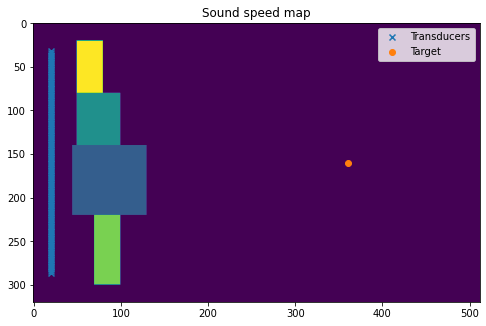

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8))

plt.imshow(medium.sound_speed)
plt.title("Sound speed map")
plt.scatter([20]*len(position),position, marker='x', label="Transducers")
plt.scatter(target[1], target[0], label="Target")
plt.legend()

In [5]:
from jwave.physics import solve_helmholtz
from jax.experimental import optimizers
from jax import jit
from tqdm import tqdm

Let's look at the solution when a constant apodization is used for all channels

In [6]:
params, solver = solve_helmholtz(
    grid, 
    medium, 
    linear_phase, 
    omega, 
    tol=1e-5, 
    solve_problem=False, 
    restart=5,
    method="gmres"
)

In [7]:
field = solver(params)

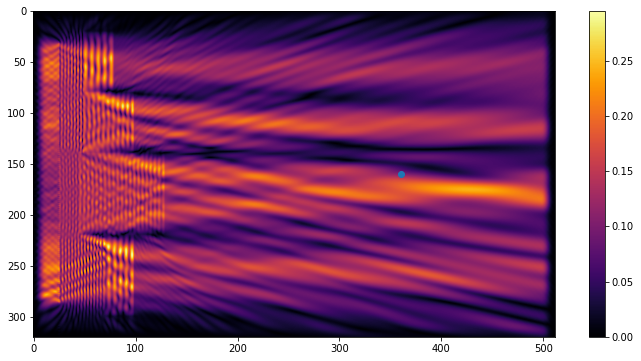

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,6))
plt.imshow(jnp.abs(field), vmin=0, cmap="inferno")
plt.colorbar()
plt.scatter(target[1], target[0], label="Target")

We can now define our loss function $L(\mathbf a)$ and perform gradient descent, to reach a local minima.

Note that this is possible because the GMRES implementation, which computes the solution of the Helmholtz problem, is differentiable. 

In [9]:
from jax import value_and_grad, vmap

In [10]:
def loss(field):
    return -jnp.abs(field[target[0],target[1]])

def get_field(transmit_phase, tol):
    transmit_field = phases_to_field(transmit_phase, grid)
    params["src"] = transmit_field
    params["solver_params"]["tol"] = tol
    return solver(params)

def full_loss(transmit_phase, tol):
    field = get_field(transmit_phase, tol)
    return loss(field), field

loss_with_grad = value_and_grad(full_loss, has_aux=True)

In [11]:
losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(transmit_phase)

@partial(jit, static_argnums=(1,))
def update(opt_state, tol):
    loss_and_field, gradient = loss_with_grad(get_params(opt_state), tol)
    lossval = loss_and_field[0]
    field = loss_and_field[1]
    return lossval, field, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
tol = 1e-3
for k in pbar:
    lossval, field, opt_state = update(opt_state, tol)
    
    if k == 0:
        avg_loss = lossval
    else:
        avg_loss = 0.5*avg_loss + 0.5*lossval
        
    if lossval > avg_loss:
        tol = max([tol/10, 1e-5])
        
    # For logging
    pbar.set_description("Tol: {} | Avg. ampl: {:01.4f} | Ampl: {:01.4f}".format(tol, -avg_loss, -lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Tol: 1e-05 | Avg. ampl: 1.0529 | Ampl: 1.0530: 100%|██████████| 100/100 [16:43<00:00, 10.03s/it]


Following is the wavefield for the optimized apodization

In [12]:
transmit_phase = get_params(opt_state)
transmit_field = phases_to_field(transmit_phase, grid)

field = solve_helmholtz(grid, medium, transmit_field, omega).block_until_ready()

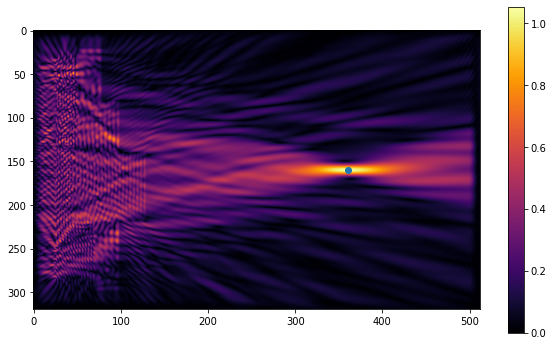

In [13]:
plt.figure(figsize=(10,6))

plt.imshow(jnp.abs(field), vmin=0., cmap="inferno")
plt.colorbar()
plt.scatter(target[1], target[0])

Note that it takes into account the heterogeneous speed of sound map. In fact, the free space beampattern for the same apodization looks very different, and in particular has a low value at the target location

In [14]:
transmit_field = phases_to_field(transmit_phase, grid)
medium_empty = Medium(
    sound_speed=jnp.ones(grid.N),
    density=1.,
    attenuation=0.0,
    pml_size=15
)
field = solve_helmholtz(grid, medium_empty, transmit_field, omega).block_until_ready()

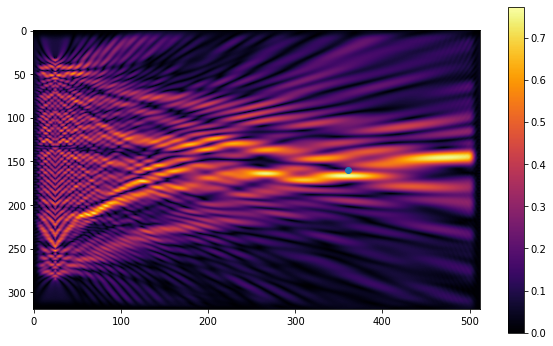

In [15]:
plt.figure(figsize=(10,6))

plt.imshow(jnp.abs(field), vmin=0., cmap="inferno")
plt.colorbar()
plt.scatter(target[1], target[0])

Lastly, we can visualize the learned apodization

Text(0.5, 1.0, 'Apodization')

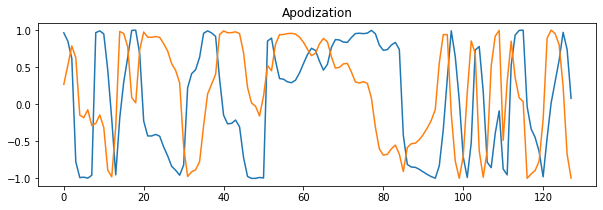

In [16]:
plt.figure(figsize=(10,3))
plt.plot(jnp.real(phase_to_apod(transmit_phase)))
plt.plot(jnp.imag(phase_to_apod(transmit_phase)))
#plt.plot(jnp.abs(phase_to_apod(transmit_phase)), "r.")
plt.title("Apodization")

Text(0.5, 1.0, 'Amplitude at target location')

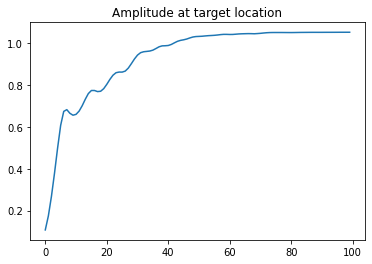

In [17]:
plt.plot(-jnp.array(losshistory))
plt.title("Amplitude at target location")

## Speed of sound gradients

In [18]:
from jwave.signal_processing import smooth

In [19]:
# Defining geometry
N = (320, 512)         # Grid size
dx = (1., 1.)          # Spatial resolution
omega = 1              # Wavefield omega = 2*pi*f
target = [60,360]     # Target location

# Making geometry
grid = kGrid.make_grid(N, dx)

src_field = jnp.zeros(N) + 0j
src_field = src_field.at[75:250, 25].set(1.)

# Constructing medium physical properties
def get_sound_speed(segments_sos, start_point=30, height=4, width=30):
    sound_speed = jnp.ones(N)
    sound_speed = sound_speed.at[20:100,150:300].set(1.6)
    sound_speed = sound_speed.at[100:140,150:300].set(2.)
    sound_speed = sound_speed.at[140:170,150:300].set(1.5)
    sound_speed = smooth(sound_speed)
    
    for k in range(len(segments_sos)):
        sound_speed = sound_speed.at[start_point+k*height:start_point+(k+1)*height, 50:50+width].add(
            jax.nn.sigmoid(segments_sos[k])
        )
    return sound_speed

In [20]:
key, _ = random.split(key)
sos = get_sound_speed(random.normal(key, shape=(65,)))

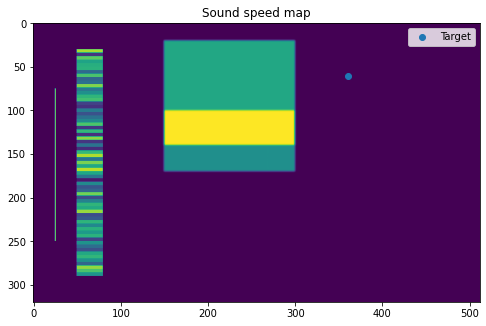

In [21]:
plt.figure(figsize=(8,8))

plt.imshow(sos + src_field.real)
plt.title("Sound speed map")
plt.scatter(target[1], target[0], label="Target")
plt.legend()

In [22]:
from jwave.physics import solve_helmholtz
from jax.experimental import optimizers
from jax import jit
from tqdm import tqdm

In [23]:
medium = Medium(
    sound_speed=sos,
    density=1.,
    attenuation=0.0,
    pml_size=15
)

In [24]:
params, solver = solve_helmholtz(grid, medium, linear_phase, omega, tol=1e-5, restart=5, solve_problem=False)

In [25]:
from jax import value_and_grad, vmap

In [26]:
def loss(field):
    return -jnp.abs(field[target[0],target[1]])

def get_field(sos_vector, tol, field):
    medium = Medium(
        sound_speed=get_sound_speed(sos_vector),
        density=1.,
        attenuation=0.0,
        pml_size=15
    )
    new_params = params
    new_params["medium"] = medium
    new_params["guess"] = field
    new_params["solver_params"]["tol"] = tol
    return solver(new_params)

def full_loss(sos_vector, tol, field):
    field = get_field(sos_vector, tol, field)
    return loss(field), field

loss_with_grad = value_and_grad(full_loss, has_aux=True)

In [27]:
losshistory = []

key, _ = random.split(key)
sos_vector = random.normal(key, shape=(65,))

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(sos_vector)

@partial(jit, static_argnums=(1,))
def update(opt_state, tol, field):
    loss_and_field, gradient = loss_with_grad(get_params(opt_state), tol, field)
    lossval = loss_and_field[0]
    field = loss_and_field[1]
    return lossval, field, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
tol = 1e-3
field = field
for k in pbar:
    lossval, field, opt_state = update(opt_state, tol, field)
    
    if k == 0:
        avg_loss = lossval
    else:
        avg_loss = 0.5*avg_loss + 0.5*lossval
        
    if lossval > avg_loss:
        tol = max([tol/10, 1e-5])
        
    # For logging
    pbar.set_description("Tol: {} | Avg. ampl: {:01.4f} | Ampl: {:01.4f}".format(tol, -avg_loss, -lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Tol: 1e-05 | Avg. ampl: 0.2838 | Ampl: 0.2846:  28%|██▊       | 28/100 [09:46<25:07, 20.93s/it] 


KeyboardInterrupt: 

Text(0.5, 1.0, 'Amplitude at target location')

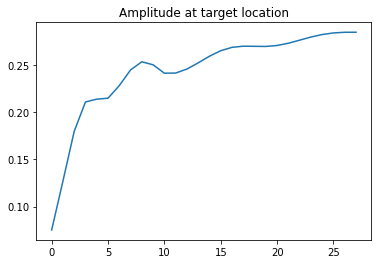

In [28]:
plt.plot(-jnp.array(losshistory))
plt.title("Amplitude at target location")

In [29]:
opt_sos_vector = get_params(opt_state)

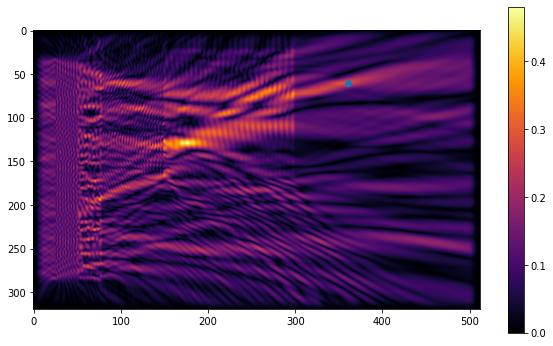

In [30]:
plt.figure(figsize=(10,6))

plt.imshow(jnp.abs(field), vmin=0., cmap="inferno")
plt.colorbar()
plt.scatter(target[1], target[0])